# Matrice de Coulomb

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))


from utils_project import generate_csv,create_dataframe_from_xyz_files,create_X_y_from_dataframe
import pandas as pd
from ase.io import read
from dscribe.descriptors import CoulombMatrix
import numpy as np
from pathlib import Path

energy_data = pd.read_csv("../../data/energies/train.csv")
df = create_dataframe_from_xyz_files("../../data/atoms/train", csv_path=None)

xyz_dir = Path("../../data/atoms/train")
xyz_files = sorted(xyz_dir.glob("*.xyz"))
max_atoms = max(len(read(f)) for f in xyz_files)
print("Le nombre d'atome max pour une molécule est de : ", max_atoms)

cm_gen = CoulombMatrix(n_atoms_max=max_atoms, permutation="sorted_l2")

coulomb_matrices = []
energies = []

for xyz_file in xyz_files:
    atoms = read(xyz_file)
    cm = cm_gen.create(atoms)
    coulomb_matrices.append(cm.flatten())

    mol_id = int(xyz_file.stem.split('_')[-1])

    energy_row = energy_data.loc[energy_data['id'] == mol_id, 'energy']
    energies.append(energy_row.values[0])

X = np.array(coulomb_matrices)
Y = np.array(energies)


Le nombre d'atome max pour une molécule est de :  23



Linear Regression
  MAE  : 1.0795
  RMSE : 1.4305
  R²   : 0.9852

Ridge Regression
  MAE  : 1.0675
  RMSE : 1.4216
  R²   : 0.9854

Random Forest
  MAE  : 0.2139
  RMSE : 0.5083
  R²   : 0.9981

Gradient Boosting
  MAE  : 0.4075
  RMSE : 0.6002
  R²   : 0.9974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103430
[LightGBM] [Info] Number of data points in the train set: 5272, number of used features: 525
[LightGBM] [Info] Start training from score -77.894083


/home/gris/miniforge3/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



LightGBM
  MAE  : 0.2480
  RMSE : 0.5037
  R²   : 0.9982


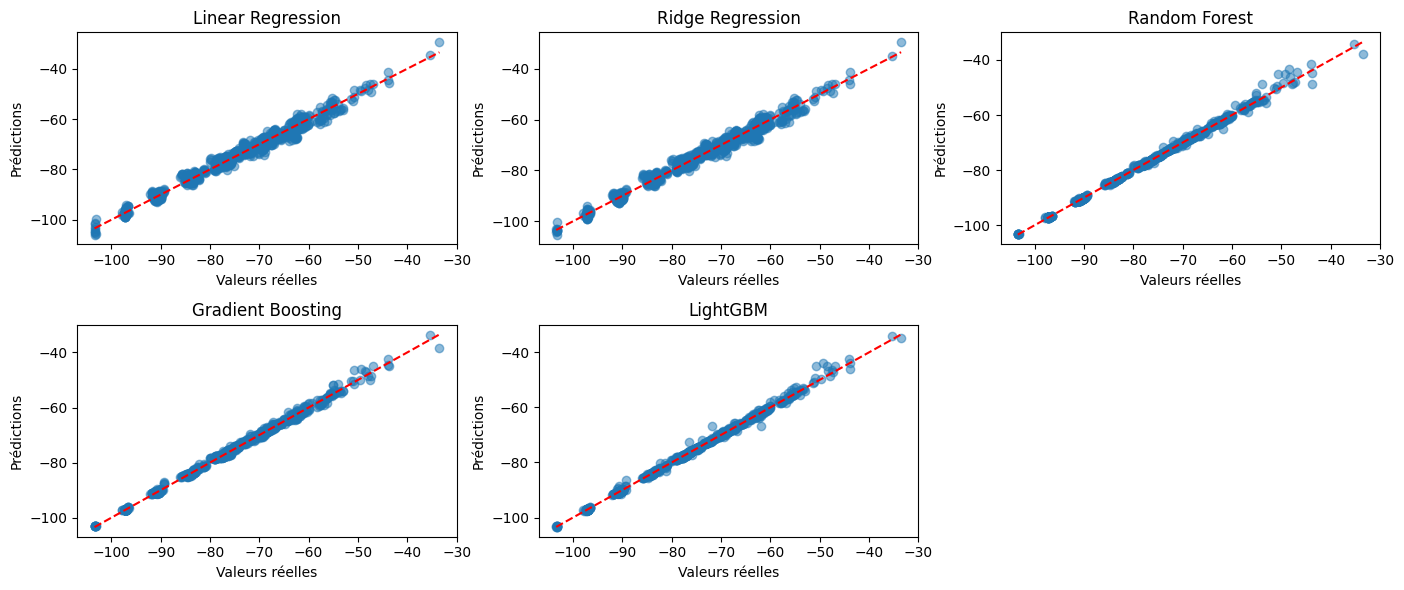

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "y_pred": y_pred
    }

    print(f"\n{name}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  R²   : {r2:.4f}")


plt.figure(figsize=(14, 6))
for i, (name, res) in enumerate(results.items(), start=1):
    plt.subplot(2, 3, i)
    plt.scatter(y_test, res["y_pred"], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Prédictions")
    plt.title(name)
plt.tight_layout()
plt.show()


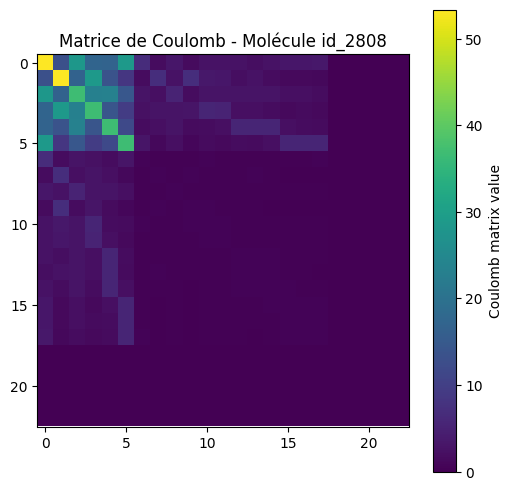

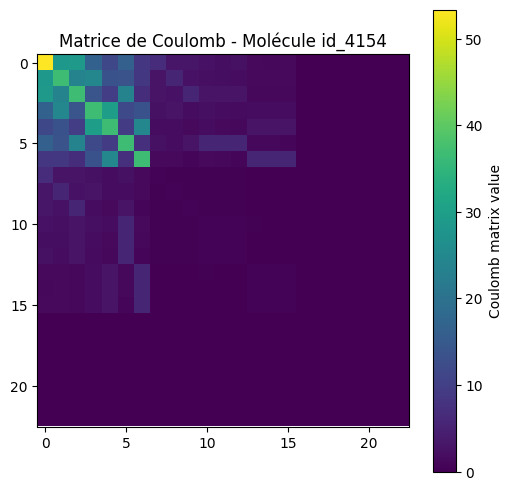

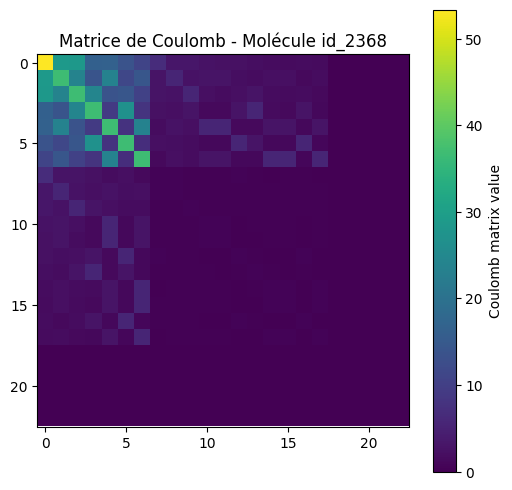

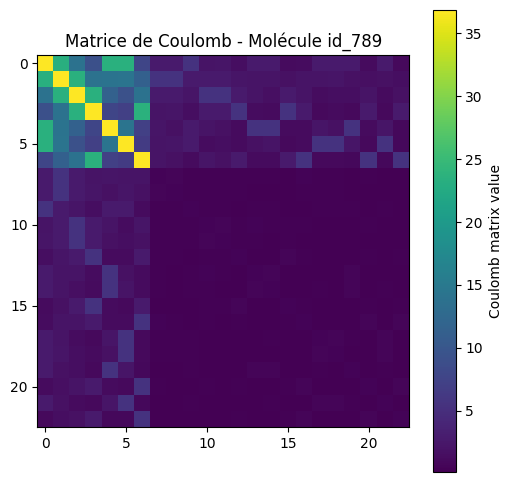

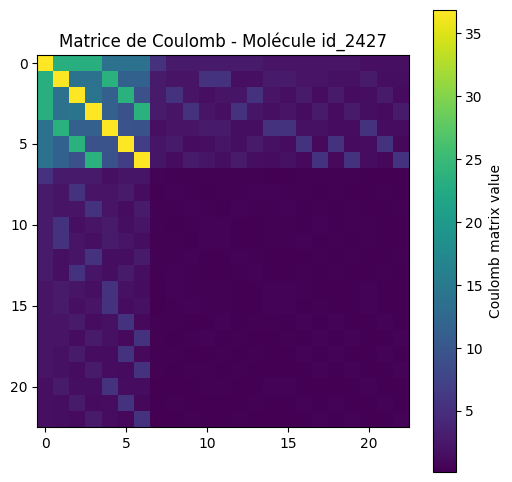

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from dscribe.descriptors import CoulombMatrix
import random
from pathlib import Path

num_to_display = 5

xyz_dir = "../../data/atoms/train"  
xyz_files = sorted(Path(xyz_dir).glob("*.xyz"))

random_xyz_files = random.sample(xyz_files, num_to_display)
cm_gen = CoulombMatrix(n_atoms_max=max_atoms, permutation="sorted_l2")

for i, xyz_file in enumerate(random_xyz_files):
    atoms = read(xyz_file) 
    cm = cm_gen.create(atoms)  
    
    if cm.ndim == 1:
        size = int(np.sqrt(len(cm)))
        cm = cm.reshape((size, size))
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Coulomb matrix value")
    plt.title(f"Matrice de Coulomb - Molécule {xyz_file.stem}")
    plt.show()
